In [1]:
import sqlite3
import pandas as pd

Database relational model 

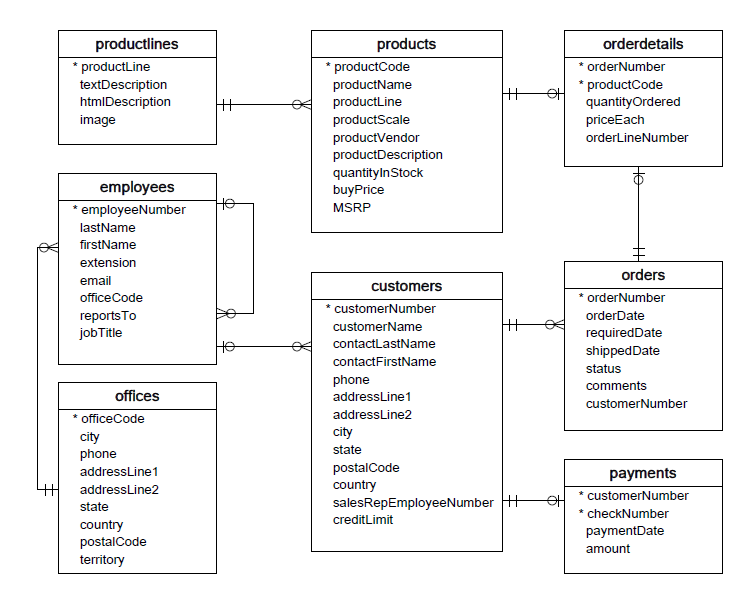

In [2]:
conn = sqlite3.connect('stores.db')
cursor = conn.cursor()

TASK 1. Which products should we order more of or less of?

The low stock represents the quantity of the sum of each product ordered divided by the quantity of product in stock. We can consider the ten highest rates. These will be the top ten products that are almost out-of-stock or completely out-of-stock.
The product performance represents the sum of sales per product.
Priority products for restocking are those with high product performance that are on the brink of being out of stock.

Low stock = SUM(quantityOrdered) / quantityInStock
Product performance = SUM(quantityOrdered * priceEach)

1.1. Write a query to compute the low stock for each product using a correlated subquery.

1.2. Write a query to compute the product performance for each product.

1.3. Combine the previous queries using a Common Table Expression (CTE) to display priority products for restocking using the IN operator.

In [ ]:
cursor.execute('''
    WITH low_stock AS (
        SELECT p.productCode, p.productName, ROUND(SUM(od.quantityOrdered) * 1.0 / p.quantityInStock, 2) AS low_stock
            FROM products p
            JOIN orderdetails od ON p.productCode = od.productCode
        GROUP BY p.productCode, p.productName),
    
    product_performance AS (
        SELECT p.productCode, SUM(od.quantityOrdered * od.priceEach) AS product_performance
            FROM orderdetails od
            JOIN products p ON od.productCode = p.productCode
        GROUP BY p.productCode),
    
    priority_products AS (
        SELECT productCode
            FROM low_stock
            WHERE low_stock < 0.5
            UNION ALL
        SELECT productCode
            FROM product_performance)   
               
    SELECT p.productCode, p.productName, ls.low_stock
        FROM low_stock ls
        JOIN products p ON p.productCode = ls.productCode
        WHERE ls.productCode IN 
               (SELECT productCode
                FROM priority_products)
    ORDER BY ls.low_stock DESC, p.productName
    LIMIT 10;   
''')

high_performance_prods = cursor.fetchall()
df = pd.DataFrame(high_performance_prods, columns=[x[0] for x in cursor.description])
df



,productCode,productName,low_stock
0,S24_2000,1960 BSA Gold Star DBD34,67.67
1,S12_1099,1968 Ford Mustang,13.72
2,S32_4289,1928 Ford Phaeton Deluxe,7.15
3,S32_1374,1997 BMW F650 ST,5.70
4,S72_3212,Pont Yacht,2.31
5,S700_3167,F/A 18 Hornet 1/72,1.90
6,S50_4713,2002 Yamaha YZR M1,1.65
7,S18_2795,1928 Mercedes-Benz SSK,1.61
8,S18_2248,1911 Ford Town Car,1.54
9,S700_1938,The Mayflower,1.22


TASK 2. How Should We Match Marketing and Communication Strategies to Customer Behavior?

This involves categorizing customers: finding the VIP (very important person) customers and those who are less engaged.
VIP customers bring in the most profit for the store.
Less-engaged customers bring in less profit.

2.1. Write a query to join the products, orders, and orderdetails tables to have customers and products information in the same place.

In [25]:
cursor.execute('''
    SELECT o.customerNumber, SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)) AS profit
        FROM orders o
        JOIN orderdetails od ON o.orderNumber = od.orderNumber
        JOIN products p ON od.productCode = p.productCode
    GROUP BY o.customerNumber
    ORDER BY profit DESC
    LIMIT 10;
''')

customer_profits = cursor.fetchall()
df = pd.DataFrame(customer_profits, columns=[x[0] for x in cursor.description])
df


,customerNumber,profit
0,141,326519.66
1,124,236769.39
2,151,72370.09
3,114,70311.07
4,119,60875.30
5,148,60477.38
6,187,60095.86
7,323,60013.99
8,131,58669.10
9,450,55931.37


TASK 3. Finding the VIP and Less Engaged Customers

Using the profit per customer from the previous query, finding VIP customers is straightforward.

3.1. Write a query to find the top five VIP customers.

3.2. Similar to the previous query, write a query to find the top five least-engaged customers.

In [39]:
cursor.execute('''
    WITH vip_customers AS(
        SELECT o.customerNumber, SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)) AS profit
        FROM orders o
        JOIN orderdetails od ON o.orderNumber = od.orderNumber
        JOIN products p ON od.productCode = p.productCode
    GROUP BY o.customerNumber
    ORDER BY profit DESC
    )
               
    SELECT c.contactLastName, c.contactFirstName, c.city, c.country, vc.profit
        FROM customers c
        JOIN vip_customers vc ON c.customerNumber = vc.customerNumber
        ORDER BY vc.profit DESC
        limit 5;
''')

vip_customers = cursor.fetchall()
vip_df = pd.DataFrame(vip_customers, columns=[x[0] for x in cursor.description])

cursor.execute('''
WITH vip_customers AS (
    SELECT o.customerNumber, SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)) AS profit
        FROM orders o
        JOIN orderdetails od ON o.orderNumber = od.orderNumber
        JOIN products p ON od.productCode = p.productCode
    GROUP BY o.customerNumber
    ORDER BY profit DESC)
               
    SELECT c.contactLastName, c.contactFirstName, c.city, c.country, vc.profit
        FROM customers c
        JOIN vip_customers vc ON c.customerNumber = vc.customerNumber
        ORDER BY vc.profit ASC
        LIMIT 5;
''')

least_vip_customers = cursor.fetchall()
df = pd.DataFrame(least_vip_customers, columns=[x[0] for x in cursor.description])
vip_df, df

(  contactLastName contactFirstName        city    country     profit
 0          Freyre           Diego       Madrid      Spain  326519.66
 1          Nelson            Susan  San Rafael        USA  236769.39
 2           Young             Jeff         NYC        USA   72370.09
 3        Ferguson            Peter   Melbourne  Australia   70311.07
 4         Labrune          Janine       Nantes     France   60875.30,
   contactLastName contactFirstName        city country    profit
 0           Young             Mary    Glendale     USA   2610.87
 1          Taylor           Leslie  Brickhaven     USA   6586.02
 2         Ricotti           Franco       Milan   Italy   9532.93
 3         Schmitt          Carine       Nantes  France  10063.80
 4           Smith          Thomas       London      UK  10868.04)